In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import pickle, datetime

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed,Convolution2D,Activation
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import RMSprop, SGD
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from tensorflow.keras.utils import ImageDataGenerator, array_to_img, img_to_array, load_img# 
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Import the backend
from keras import backend as K
# K.tensorflow_backend._get_available_gpus()
tf.test.gpu_device_name()
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
my_arrays_final = np.load("/content/drive/MyDrive/numpy_data_CNN.npz", allow_pickle=True)


In [4]:
# Extract the X_train, y_train, X_test, and y_test arrays from the data
X_train = my_arrays_final['X_train']
y_train = my_arrays_final['y_train']
X_test = my_arrays_final['X_test']
y_test = my_arrays_final['y_test']

In [5]:
# Print the shapes of the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (6052, 227, 227, 3)
y_train shape: (6052,)
X_test shape: (1514, 227, 227, 3)
y_test shape: (1514,)


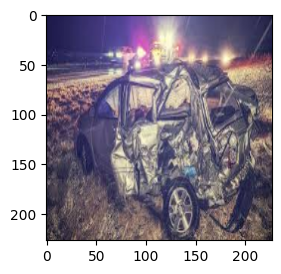

In [8]:
plt.subplot(121)
img = np.reshape(X_train[1], (227,227,3))
plt.imshow(img)

In [6]:
def get_alexnet(input_shape,nb_classes): 
    # Layer 1
    model = Sequential()
    model.add(Convolution2D(96, 11, 11, input_shape = input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Convolution2D(128, 5, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

    # Layer 3
    model.add(ZeroPadding2D((2,2)))  # add additional padding
    model.add(Convolution2D(384, 3, 3, padding='same'))
    model.add(Activation('relu'))

    # Layer 4
    model.add(ZeroPadding2D((2,2)))  # add additional padding
    model.add(Convolution2D(192, 3, 3, padding='same'))
    model.add(Activation('relu'))

    # Layer 5
    model.add(ZeroPadding2D((2,2)))  # add additional padding
    model.add(Convolution2D(128, 3, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 6
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 8
    model.add(Dense(nb_classes, kernel_initializer='glorot_normal'))
    model.add(Activation('tanh'))

    return model

In [7]:
N_CATEGORY = 3

In [8]:
alexnet = get_alexnet((227,227,3),N_CATEGORY)
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 21, 96)        34944     
                                                                 
 activation (Activation)     (None, 21, 21, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         307328    
                                                                 
 activation_1 (Activation)   (None, 2, 2, 128)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                    

In [43]:
# Set the random seed for reproducibility
np.random.seed(42)

# Select 2000 random indices from the range of indices corresponding to the rows of X_train and y_train
indices = np.random.choice(len(X_train), size=1500, replace=False)

# Create new arrays containing only the selected rows
X_train_subset = X_train[indices]
y_train_subset = y_train[indices]

In [44]:
X_train_subset.shape, y_train_subset.shape

((1500, 227, 227, 3), (1500,))

In [47]:
# y_train.shape, y_test.shape

In [46]:
indices = np.random.choice(len(X_test), size=500, replace=False)
X_test_subset = X_test[indices]
y_test_subset = y_test[indices]

In [48]:
X_test_subset.shape, y_test_subset.shape

((500, 227, 227, 3), (500,))

In [49]:
unique_classes = np.unique(y_train_subset)
print(unique_classes)

[0 1 2]


In [50]:
# Get the unique class values and their counts from y_train_subset
unique_classes, class_counts = np.unique(y_train_subset, return_counts=True)

for i in range(len(unique_classes)):
    print("Class {}: {} samples".format(unique_classes[i], class_counts[i]))

Class 0: 469 samples
Class 1: 507 samples
Class 2: 524 samples


In [51]:
# Get the unique class values and their counts from y_train_subset
unique_classes, class_counts = np.unique(y_test_subset, return_counts=True)

for i in range(len(unique_classes)):
    print("Class {}: {} samples".format(unique_classes[i], class_counts[i]))

Class 0: 161 samples
Class 1: 170 samples
Class 2: 169 samples


In [52]:
# def data_generator(x, y, batch_size=32):
#     num_samples = len(x)
#     while True:
#         indices = np.random.randint(0, num_samples, batch_size)
#         batch_x = x[indices]
#         batch_y = y[indices]
#         # normalize images
#         batch_x_normalized = batch_x / 255.0 - 0.5
#         # one-hot encode labels
#         label_binarizer = LabelBinarizer()
#         batch_y_one_hot = label_binarizer.fit_transform(batch_y)
#         yield batch_x_normalized, batch_y_one_hot, len(indices)


In [18]:
# steps_per_epoch = len(X_train) // batch_size
# validation_steps = len(X_val) // batch_size
# history = alexnet.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, 
#                                 validation_data=val_generator, validation_steps=validation_steps)


In [53]:
#Normalization of the images and one-hot encoding of the labels
alexnet.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
X_normalized = np.array(X_train_subset / 255.0 - 0.5 )
X_normalized_test = np.array(X_test_subset / 255.0 - 0.5 )

label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train_subset)
y_one_hot_test = label_binarizer.fit_transform(y_test_subset)


In [54]:
#Training the AlexNet model with the normalized image data and labels
alexnet.fit(X_normalized, y_one_hot, batch_size=5, epochs=100,verbose=1, validation_data=[X_normalized_test,y_one_hot_test])


Epoch 1/100
300/300 [==============================] - 7s 17ms/step - loss: 9.1229 - accuracy: 0.3127 - val_loss: 10.9281 - val_accuracy: 0.3220
Epoch 2/100
300/300 [==============================] - 4s 14ms/step - loss: 8.9832 - accuracy: 0.3127 - val_loss: 10.9281 - val_accuracy: 0.3220
Epoch 3/100
300/300 [==============================] - 5s 15ms/step - loss: 8.9617 - accuracy: 0.3127 - val_loss: 10.9281 - val_accuracy: 0.3220
Epoch 4/100
300/300 [==============================] - 4s 15ms/step - loss: 9.0047 - accuracy: 0.3127 - val_loss: 10.9281 - val_accuracy: 0.3220
Epoch 5/100
300/300 [==============================] - 4s 15ms/step - loss: 9.0691 - accuracy: 0.3127 - val_loss: 10.9281 - val_accuracy: 0.3220
Epoch 6/100
300/300 [==============================] - 5s 16ms/step - loss: 9.0262 - accuracy: 0.3127 - val_loss: 10.9281 - val_accuracy: 0.3220
Epoch 7/100
300/300 [==============================] - 4s 14ms/step - loss: 9.3163 - accuracy: 0.3127 - val_loss: 10.9281 - val_ac

In [55]:
#Save the AlexNet model for the future use(as it takes hours to be trained!)
alexnet.save('/content/drive/MyDrive/alexnetcar.h5') 


In [56]:
#Pick the first Fully-Connected layer as the features which will be of dimension (1 x 4096)
layer_name = 'dense_1'
FC_layer_model = Model(inputs=alexnet.input,
                                 outputs=alexnet.get_layer(layer_name).output)

In [ ]:
i = 0
features = np.zeros(shape=(X_train_subset.shape[0], 4096))
for img in X_train_subset:
    img = cv2.resize(img, (227, 227))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img, axis=0)
    FC_output = FC_layer_model.predict(img)
    features[i] = FC_output
    i += 1

In [30]:
# img = cv2.resize(X_train[1], (227, 227))
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# img = np.expand_dims(img, axis=0)
 

In [58]:
features

array([[-4.55891037, 17.92090607,  2.81907654, ..., -4.18829393,
         6.2576642 , -5.65228558],
       [-5.35002613, 21.14528656,  3.33133245, ..., -4.89208078,
         7.34010887, -6.58629847],
       [-4.13897228, 16.44618607,  2.51374817, ..., -3.85227251,
         5.7321229 , -5.17536354],
       ...,
       [-3.3591485 , 13.34490299,  2.15066385, ..., -3.09928441,
         4.68369436, -4.20405722],
       [-5.05153275, 19.83300591,  3.17135143, ..., -4.63835192,
         6.9034977 , -6.26627922],
       [-4.15221024, 16.4957695 ,  2.61361933, ..., -3.8323009 ,
         5.72461414, -5.14508152]])

In [59]:
#Save the features of the train images to use it in future.
np.save('features', features)


In [60]:
#Name the feature rows as f_0, f_1, f_2...
feature_col=[]
for i in range(4096):
    feature_col.append("f_"+str(i))
    i+=1

In [61]:
#Create DataFrame with features and coloumn name
train_features=pd.DataFrame(data=features,columns=feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(y_train_subset))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', y_train_subset.shape)
train_class

Training Features Shape: (1500, 4096)
Training Labels Shape: (1500,)


[0, 1, 2]

In [62]:
train_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_4086,f_4087,f_4088,f_4089,f_4090,f_4091,f_4092,f_4093,f_4094,f_4095
0,-4.558910,17.920906,2.819077,9.245107,21.498182,-5.744046,-8.768895,-6.623530,-3.975899,1.865618,...,0.338386,1.279653,-6.396715,4.898255,12.449568,-4.259824,-11.813265,-4.188294,6.257664,-5.652286
1,-5.350026,21.145287,3.331332,10.946732,25.349888,-6.722966,-10.429466,-7.785144,-4.670996,2.244188,...,0.353872,1.599890,-7.524804,5.861196,14.717688,-5.045650,-13.990904,-4.892081,7.340109,-6.586298
2,-4.138972,16.446186,2.513748,8.523713,19.742655,-5.279372,-8.038150,-6.065151,-3.674265,1.781848,...,0.299008,1.171414,-5.851619,4.515604,11.403030,-3.893006,-10.889793,-3.852273,5.732123,-5.175364
3,-5.608788,22.059462,3.464304,11.373669,26.430214,-7.059974,-10.794853,-8.122313,-4.892334,2.327092,...,0.402460,1.623382,-7.875875,6.032021,15.342137,-5.193876,-14.573708,-5.142886,7.689032,-6.948287
4,-3.856339,15.265209,2.340381,7.900493,18.214298,-4.850739,-7.459589,-5.581739,-3.368736,1.650686,...,0.221181,1.108207,-5.516487,4.178170,10.636197,-3.548739,-10.078203,-3.514907,5.304350,-4.734000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-4.117678,16.296432,2.591136,8.432635,19.558374,-5.250350,-7.925411,-5.967737,-3.607046,1.690467,...,0.313843,1.188931,-5.792178,4.455268,11.285853,-3.884708,-10.723838,-3.825039,5.686565,-5.115285
1496,-5.608056,22.004959,3.458739,11.344529,26.387791,-7.050234,-10.780788,-8.115902,-4.851971,2.311837,...,0.400128,1.607216,-7.876758,6.026596,15.310979,-5.191762,-14.541243,-5.132689,7.674044,-6.930846
1497,-3.359149,13.344903,2.150664,6.878142,16.052687,-4.280793,-6.561216,-4.953110,-2.942507,1.373453,...,0.279387,0.954572,-4.793821,3.695992,9.266873,-3.187512,-8.796401,-3.099284,4.683694,-4.204057
1498,-5.051533,19.833006,3.171351,10.195879,23.804903,-6.337742,-9.752759,-7.315308,-4.364041,2.051524,...,0.385592,1.466437,-7.088389,5.468581,13.798578,-4.712828,-13.051393,-4.638352,6.903498,-6.266279


In [63]:
y_test_subset.shape[0]

500

In [ ]:
i = 0
features_test = np.zeros(shape=(X_test_subset.shape[0], 4096))
for img in X_test_subset:
    img = cv2.resize(img, (227, 227))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img, axis=0)
    FC_output = FC_layer_model.predict(img)
    features_test[i] = FC_output
    i += 1

In [65]:
#Create DataFrame with features and coloumn name
test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', y_test_subset.shape)


Test Features Shape: (500, 4096)
Test Labels Shape: (500,)


In [66]:
test_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_4086,f_4087,f_4088,f_4089,f_4090,f_4091,f_4092,f_4093,f_4094,f_4095
0,-5.124830,20.190920,3.136094,10.461378,24.155279,-6.402221,-9.908097,-7.419732,-4.487391,2.131548,...,0.310846,1.508099,-7.245104,5.539833,14.075217,-4.748391,-13.327959,-4.675350,7.022776,-6.291299
1,-4.284396,16.812651,2.697795,8.627807,20.171480,-5.374651,-8.279762,-6.198057,-3.681363,1.739561,...,0.312046,1.273034,-6.013856,4.625897,11.716662,-3.969255,-11.072102,-3.912079,5.861216,-5.294683
2,-5.135418,20.254841,3.161444,10.402322,24.233278,-6.489452,-9.884250,-7.433170,-4.490126,2.131135,...,0.356681,1.466637,-7.216687,5.545760,14.075558,-4.739575,-13.372047,-4.741791,7.060275,-6.404980
3,-3.529792,14.219090,2.214573,7.358703,17.092648,-4.522105,-6.979711,-5.206910,-3.126649,1.446528,...,0.173578,1.077403,-5.050498,3.970732,9.908401,-3.367099,-9.455235,-3.309070,4.949045,-4.406476
4,-3.716273,14.607755,2.151808,7.433151,17.693060,-4.814672,-7.051993,-5.401560,-3.193106,1.575807,...,0.362953,1.025877,-5.169869,3.999006,10.084679,-3.445570,-9.702131,-3.546592,5.083253,-4.622549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-4.165774,16.225876,2.570994,8.419689,19.398556,-5.154207,-7.981774,-5.972471,-3.665075,1.732270,...,0.253389,1.191474,-5.829919,4.414390,11.318823,-3.823048,-10.714513,-3.747692,5.663626,-5.112822
496,-4.125546,16.353346,2.593356,8.452286,19.584501,-5.198465,-8.012907,-6.021468,-3.604354,1.690444,...,0.325293,1.192169,-5.858001,4.499550,11.340139,-3.888309,-10.765052,-3.827476,5.687869,-5.152288
497,-4.460889,17.535587,2.752986,8.999648,20.996611,-5.615289,-8.512895,-6.454937,-3.882571,1.846524,...,0.391642,1.336978,-6.139956,4.757302,12.078087,-4.186415,-11.546366,-4.173518,6.075006,-5.547140
498,-4.545998,17.988605,2.816658,9.231334,21.565390,-5.786835,-8.742294,-6.618176,-3.971695,1.873164,...,0.320352,1.283418,-6.399114,4.937599,12.455957,-4.242768,-11.889994,-4.267169,6.267802,-5.691453


In [67]:
#Feed the extracted features with the labels to RANDOM FOREST 
rf = RandomForestClassifier(n_estimators = 20, random_state = 42,max_features=4)

rf.fit(train_features, y_train_subset)


RandomForestClassifier(max_features=4, n_estimators=20, random_state=42)

In [68]:
#Feed the features of the test images to Random Forest Classifier to predict its class
predictions = rf.predict(test_features)


In [69]:
accuracy=accuracy_score(predictions , y_test_subset)
print('Accuracy:', accuracy*100, '%.')


Accuracy: 34.8 %.


In [41]:
# #Find the Features for n number of train images and we will get n x 4096
# #This means we will get 4096 features for each images.
# i=0
# features=np.zeros(shape=(X_train_subset.shape[0],4096))
# for directory_path in glob.glob("/content/drive/MyDrive/car_data/minor_1.jpeg"):
#          print(directory_path)
#         #  for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
#         #    print(img_path)
#          img = cv2.imread(directory_path, cv2.IMREAD_COLOR)    
#          img = cv2.resize(img, (227, 227))
#          img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#          img = np.expand_dims(img, axis=0)
#          FC_output = FC_layer_model.predict(img)
#          print(FC_output)
#          features[i]=FC_output
#          i+=1

In [36]:
X_train_subset.shape[0]

1000

In [37]:
features.shape

(1000, 4096)

In [70]:
# img_path="/content/drive/MyDrive/car_data/minor_1.jpeg"
# img = cv2.imread(img_path, cv2.IMREAD_COLOR)
# img = cv2.resize(img, (227, 227))
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# plt.imshow(img)
# img = np.expand_dims(img, axis=0)
# FC_output = FC_layer_model.predict(img)
# image_features=pd.DataFrame(data=FC_output,columns=feature_col)
# predictions = rf.predict(image_features)
# print("It's",y_test_subset[predictions[0]])